In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

In [2]:
# Load Nasdaq QDL/FON dataset (assumed CSV format)
# online source = NASDAQ Data Link: QDL-FON dataset
cftc_data = pd.read_csv("QDL-FON.csv")  # Replace with actual file

In [3]:
# Load historical commodity prices (e.g., gold, crude oil)
# online source = https://www.kaggle.com/datasets/debashish311601/commodity-prices?select=commodity_futures.csv
commodity_prices = pd.read_csv("commodity_futures.csv")  # Replace with actual file

In [4]:
# Convert Date to datetime format
cftc_data['Date'] = pd.to_datetime(cftc_data['Date'])
commodity_prices['Date'] = pd.to_datetime(commodity_prices['Date'])

In [5]:
# Select a commodity to analyze (e.g., GOLD)
commodity = 'GOLD'

In [6]:
# Merge datasets on Date
data = pd.merge(cftc_data, commodity_prices[['Date', commodity]], on='Date', how='inner')

In [7]:
# Feature Engineering - Create net positions
data['Net_Producer_Pos'] = data['Producer_merchant_processor_user_longs'] - data['Producer_merchant_processor_user_shorts']
data['Net_Swap_Dealer_Pos'] = data['Swap_dealer_longs'] - data['Swap_dealer_shorts']
data['Net_Money_Manager_Pos'] = data['Money_manager_longs'] - data['Money_manager_shorts']
data['Net_Other_Reportable_Pos'] = data['Other_reportable_longs'] - data['Other_reportable_shorts']

In [8]:
data['Price_Change'] = data[commodity].pct_change()  # Daily percentage change
data['Target_Class'] = (data['Price_Change'] > 0).astype(int)  # 1 = Up, 0 = Down
data.dropna(inplace=True)

In [9]:
# Select features
features = ['Net_Producer_Pos', 'Net_Swap_Dealer_Pos', 'Net_Money_Manager_Pos', 'Net_Other_Reportable_Pos']
X = data[features]
y_class = data['Target_Class']  # Classification target
y_reg = data['Price_Change']  # Regression target

In [10]:
# Train-test split
X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [11]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Classification Model - Predict Up/Down movement
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_class_train)
y_class_pred = clf.predict(X_test)

In [13]:
print("Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))

Classification Accuracy: 0.7505


In [14]:
# Regression Model - Predict Price Change Magnitude
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_reg_train)
y_reg_pred = reg.predict(X_test)

In [15]:
print("Regression MAE:", mean_absolute_error(y_reg_test, y_reg_pred))
print("Regression RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)))

Regression MAE: 0.011686544265522045
Regression RMSE: 0.02003232810174133


In [16]:
importances = clf.feature_importances_

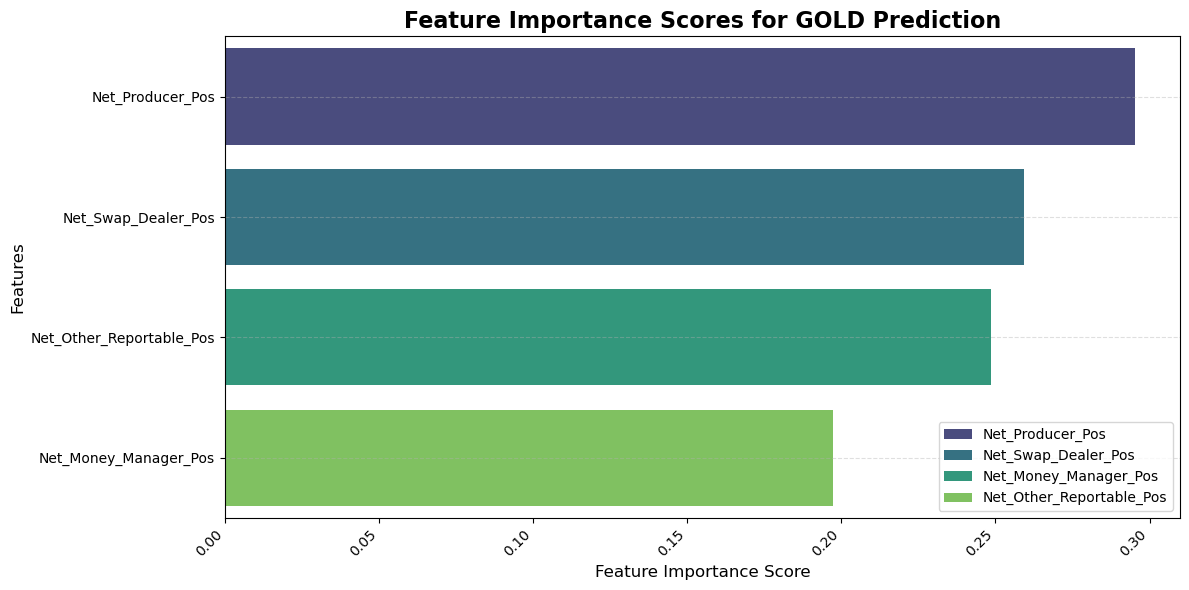

In [17]:
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(12, 6))  # Adjust figure size for better readability

# Use a sequential color palette
palette = sns.color_palette("viridis", len(feature_importance)) # or "Blues_r", "rocket" etc.

sns.barplot(x=feature_importance.values, y=feature_importance.index, hue=features, palette=palette)

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability, adjust ha as needed.
plt.title(f"Feature Importance Scores for {commodity} Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4) # less opacity for the grid
plt.tight_layout()

plt.show()

In [18]:
numerical_cols = data.select_dtypes(include=['number']).columns

In [19]:
# Resample to monthly and quarterly frequency, selecting only numerical columns
data_monthly = data.resample('ME', on='Date')[numerical_cols].mean()
data_quarterly = data.resample('QE', on='Date')[numerical_cols].mean()

In [20]:
def add_features(df):
    df['Net_Producer_Pos'] = df['Producer_merchant_processor_user_longs'] - df['Producer_merchant_processor_user_shorts']
    df['Net_Swap_Dealer_Pos'] = df['Swap_dealer_longs'] - df['Swap_dealer_shorts']
    df['Net_Money_Manager_Pos'] = df['Money_manager_longs'] - df['Money_manager_shorts']
    df['Net_Other_Reportable_Pos'] = df['Other_reportable_longs'] - df['Other_reportable_shorts']
    df['Price_Change'] = df[commodity].pct_change(fill_method=None)  # Percentage change over the period
    df['Target_Class'] = (df['Price_Change'] > 0).astype(int)  # 1 = Up, 0 = Down
    df.dropna(inplace=True)
    return df

In [21]:
data_monthly = add_features(data_monthly)
data_quarterly = add_features(data_quarterly)

In [22]:
# Select features
features = ['Net_Producer_Pos', 'Net_Swap_Dealer_Pos', 'Net_Money_Manager_Pos', 'Net_Other_Reportable_Pos']

In [23]:
# Function to train and evaluate models
def train_evaluate(df, period):
    X = df[features]
    y_class = df['Target_Class']  # Classification target
    y_reg = df['Price_Change']  # Regression target

    # Train-test split
    X_train, X_test, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Classification Model - Predict Up/Down movement
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_class_train)
    y_class_pred = clf.predict(X_test)
    print(f"{period} Classification Accuracy:", accuracy_score(y_class_test, y_class_pred))

    # Regression Model - Predict Price Change Magnitude
    reg = RandomForestRegressor(n_estimators=100, random_state=42)
    reg.fit(X_train, y_reg_train)
    y_reg_pred = reg.predict(X_test)
    print(f"{period} Regression MAE:", mean_absolute_error(y_reg_test, y_reg_pred))
    print(f"{period} Regression RMSE:", np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)))

    feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
    
    # Use a sequential color palette
    palette = sns.color_palette("viridis", len(feature_importance)) # or "Blues_r", "rocket" etc.
    
    sns.barplot(x=feature_importance.values, y=feature_importance.index, hue=features, palette=palette)
    
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability, adjust ha as needed.
    plt.title(f"Feature Importances for {commodity} Prediction ({period})", fontsize=16, fontweight='bold')
    plt.xlabel("Feature Importance Score", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4) # less opacity for the grid
    plt.tight_layout()
    
    plt.show()

Monthly Classification Accuracy: 0.6956521739130435
Monthly Regression MAE: 0.03158687619871909
Monthly Regression RMSE: 0.04533405071565666


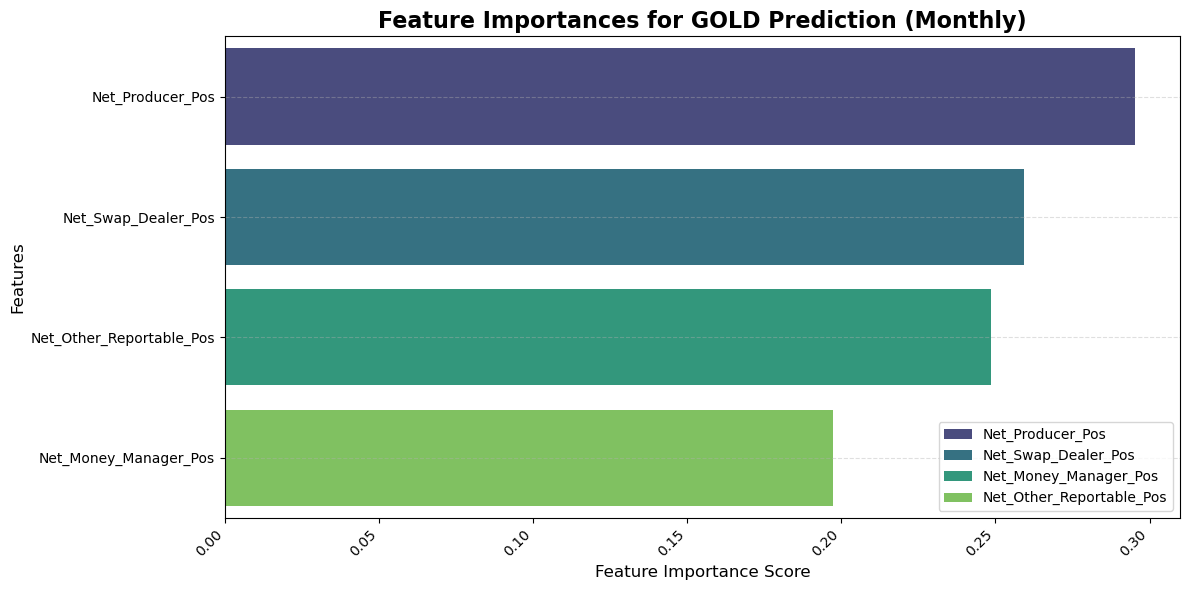

In [24]:
# Train and evaluate for monthly and quarterly trends
train_evaluate(data_monthly, "Monthly")

Quarterly Classification Accuracy: 0.5
Quarterly Regression MAE: 0.05967730292181616
Quarterly Regression RMSE: 0.06475424429465108


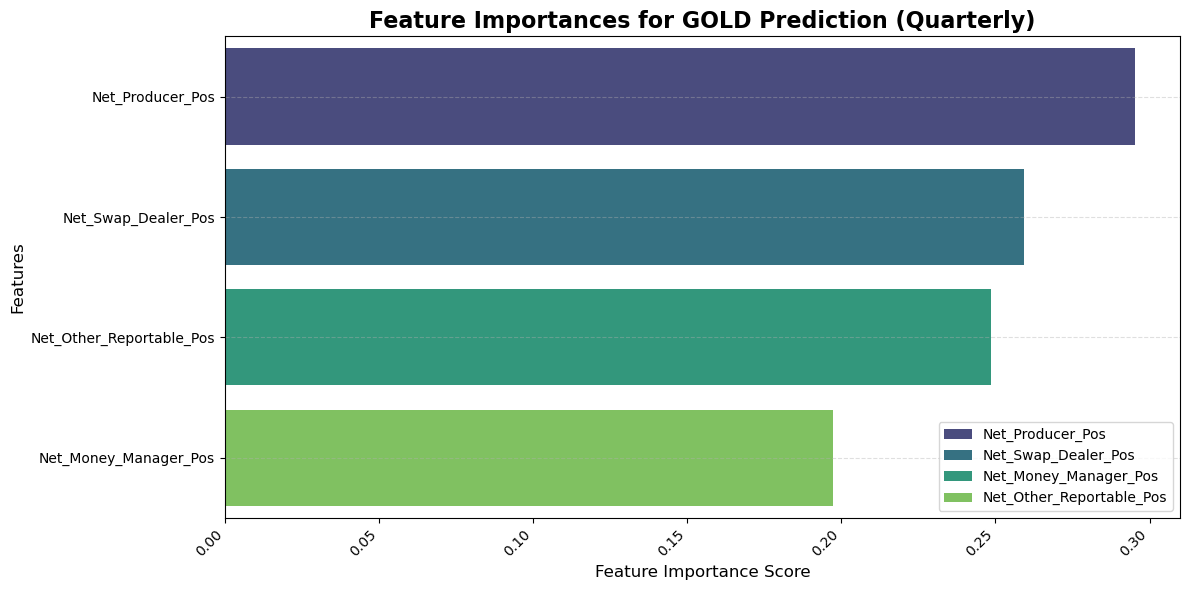

In [25]:
train_evaluate(data_quarterly, "Quarterly")

In [26]:
from scipy.signal import argrelextrema

In [35]:
# Feature Engineering - Create net positions
def add_features(df):
    df['Net_Producer_Pos'] = df['Producer_merchant_processor_user_longs'] - df['Producer_merchant_processor_user_shorts']
    df['Net_Swap_Dealer_Pos'] = df['Swap_dealer_longs'] - df['Swap_dealer_shorts']
    df['Net_Money_Manager_Pos'] = df['Money_manager_longs'] - df['Money_manager_shorts']
    df['Net_Other_Reportable_Pos'] = df['Other_reportable_longs'] - df['Other_reportable_shorts']
    df['Price_Change'] = df[commodity].pct_change(fill_method=None)
    df['SMA_10'] = df[commodity].rolling(window=10).mean()
    df['SMA_50'] = df[commodity].rolling(window=50).mean()
    df.dropna(inplace=True)
    return df

In [36]:
# Identify numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns

In [37]:
# Resample to monthly and quarterly frequency, selecting only numerical columns
data_weekly = data.resample('W', on='Date')[numerical_cols].mean()

In [38]:
data_weekly = add_features(data_weekly)

In [39]:
# Identify Turning Points
def identify_turning_points(df):
    df['Min'] = df[commodity].iloc[argrelextrema(df[commodity].values, np.less, order=5)[0]]
    df['Max'] = df[commodity].iloc[argrelextrema(df[commodity].values, np.greater, order=5)[0]]
    df['Turning_Point'] = 0
    df.loc[df['Min'].notna(), 'Turning_Point'] = -1  # Troughs
    df.loc[df['Max'].notna(), 'Turning_Point'] = 1   # Peaks
    df.drop(columns=['Min', 'Max'], inplace=True)
    return df

In [40]:
data_weekly = identify_turning_points(data_weekly)

In [41]:
# Select features and target
features = ['Net_Producer_Pos', 'Net_Swap_Dealer_Pos', 'Net_Money_Manager_Pos', 'Net_Other_Reportable_Pos', 'SMA_10', 'SMA_50']
X = data_weekly[features]
y = data_weekly['Turning_Point']

In [42]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
# Classification Model - Predict Turning Points
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
# Evaluate Model
print("Turning Points Classification Accuracy:", accuracy_score(y_test, y_pred))

Turning Points Classification Accuracy: 0.9066666666666666


In [47]:
# Plot Feature Importances
importances = clf.feature_importances_

C:\Users\dell\AppData\Local\Temp\ipykernel_9556\186171725.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=palette, orient='h')


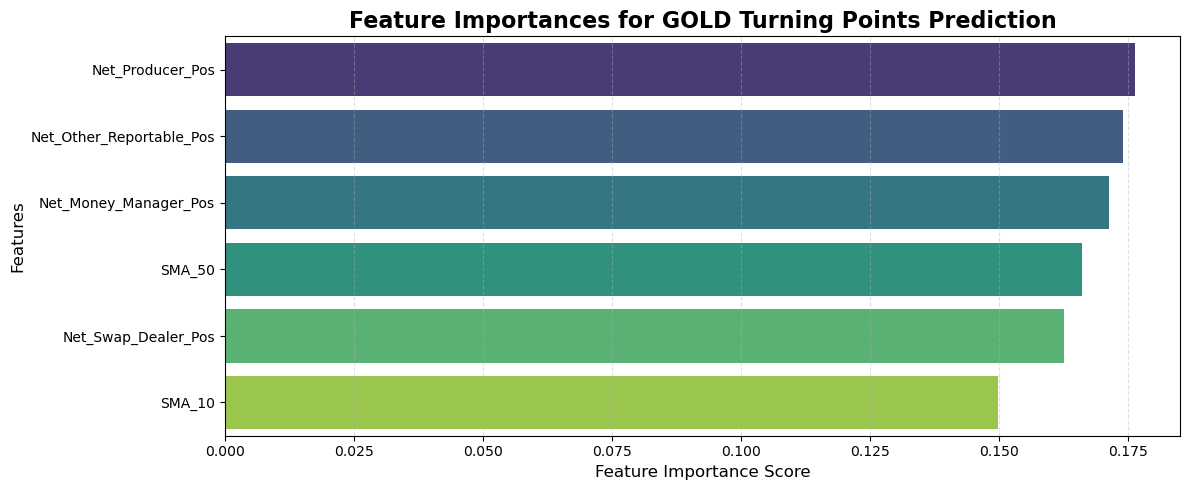

In [48]:
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(12, 5))  # Adjust figure size for better readability (increased height)

# Use a sequential color palette
palette = sns.color_palette("viridis", len(feature_importance))  # or "Blues_r", "rocket" etc.

# Horizontal bar plot (swap x and y)
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette=palette, orient='h')

# Rotate y-axis labels (no rotation needed for horizontal)
# plt.yticks(rotation=45, ha='right') # no longer needed.

plt.title(f"Feature Importances for {commodity} Turning Points Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Remove the legend entirely
# plt.legend() #remove this line

plt.grid(axis='x', linestyle='--', alpha=0.4)  # Grid on x-axis for horizontal bars
plt.tight_layout()
plt.show()

In [49]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.dates as mdates

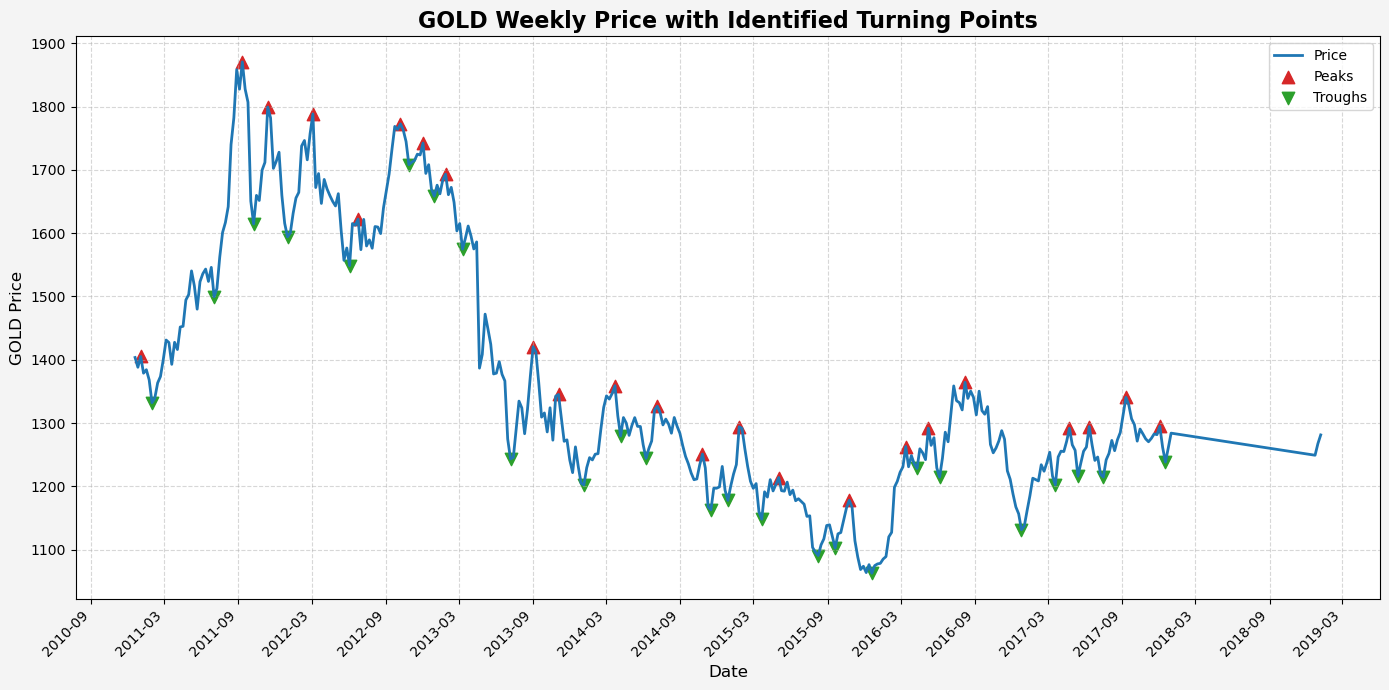

In [50]:
plt.figure(figsize=(14, 7), facecolor='#f4f4f4')  # Light background color

# Price line
plt.plot(data_weekly.index, data_weekly[commodity], label='Price', color='#1f77b4', linewidth=2, linestyle='-')  # Darker blue, thicker line

# Peaks
plt.scatter(
    data_weekly.index[data_weekly['Turning_Point'] == 1],
    data_weekly[commodity][data_weekly['Turning_Point'] == 1],
    color='#d62728',  # Red
    label='Peaks',
    marker='^',
    s=80,  # Increased marker size
)

# Troughs
plt.scatter(
    data_weekly.index[data_weekly['Turning_Point'] == -1],
    data_weekly[commodity][data_weekly['Turning_Point'] == -1],
    color='#2ca02c',  # Green
    label='Troughs',
    marker='v',
    s=80,  # Increased marker size
)

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) #adjust the interval as needed.
plt.xticks(rotation=45, ha='right')

# Labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{commodity} Price', fontsize=12)
plt.title(f'{commodity} Weekly Price with Identified Turning Points', fontsize=16, fontweight='bold')

# Legend
plt.legend(loc='best', fontsize=10) #location best will find the best spot for the legend.

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [51]:
# Trader Behavior Analysis - Clustering large traders
trader_features = ['Net_Producer_Pos', 'Net_Swap_Dealer_Pos', 'Net_Money_Manager_Pos', 'Net_Other_Reportable_Pos']
trader_data = data_weekly[trader_features]
scaler = StandardScaler()
trader_data_scaled = scaler.fit_transform(trader_data)

In [52]:
# Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_weekly['Trader_Cluster'] = kmeans.fit_predict(trader_data_scaled)

C:\Users\dell\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


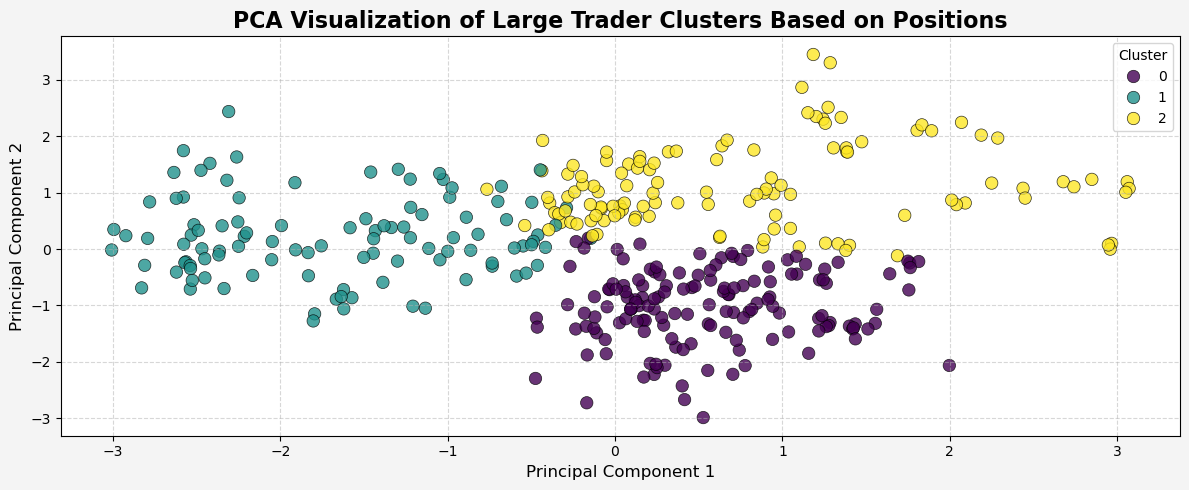

In [53]:
pca = PCA(n_components=2)
trader_pca = pca.fit_transform(trader_data_scaled)

plt.figure(figsize=(12, 5), facecolor='#f4f4f4')  # Light background color

sns.scatterplot(
    x=trader_pca[:, 0],
    y=trader_pca[:, 1],
    hue=data_weekly['Trader_Cluster'],
    palette='viridis',  # Or use a more distinct palette like 'tab10' or 'Set1'
    s=80,  # Adjust marker size
    alpha=0.8,  # Adjust marker opacity
    edgecolor='black', #add edge color
    linewidth=0.5
)

plt.title("PCA Visualization of Large Trader Clusters Based on Positions", fontsize=16, fontweight='bold')
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Cluster", fontsize=10)

plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(fontsize=10) #adjust tick sizes
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [54]:
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest

In [55]:
# Detect Market Manipulation - Anomaly Detection
z_scores = np.abs(zscore(trader_data))
anomaly_threshold = 3
data_weekly['Anomaly_Zscore'] = (z_scores > anomaly_threshold).sum(axis=1) > 0

In [56]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data_weekly['Anomaly_IsolationForest'] = iso_forest.fit_predict(trader_data_scaled) == -1

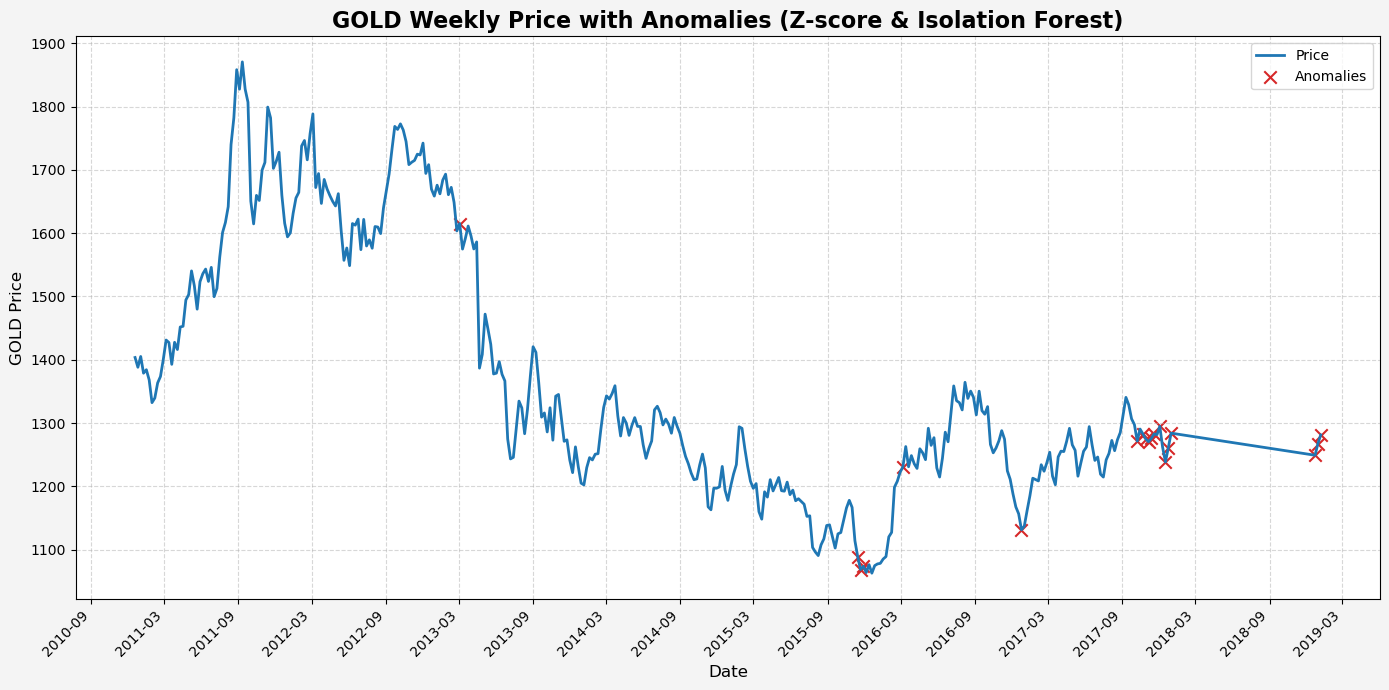

In [57]:
data_weekly['Anomaly'] = data_weekly[['Anomaly_Zscore', 'Anomaly_IsolationForest']].any(axis=1)

plt.figure(figsize=(14, 7), facecolor='#f4f4f4')  # Light background color

# Price line
plt.plot(data_weekly.index, data_weekly[commodity], label='Price', color='#1f77b4', linewidth=2, linestyle='-')  # Darker blue, thicker line

# Anomalies
plt.scatter(
    data_weekly.index[data_weekly['Anomaly']],
    data_weekly[commodity][data_weekly['Anomaly']],
    color='#d62728',  # Red
    label='Anomalies',
    marker='x',
    s=80,  # Increased marker size
)

# Date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) #adjust the interval as needed.
plt.xticks(rotation=45, ha='right')

# Labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel(f'{commodity} Price', fontsize=12)
plt.title(f'{commodity} Weekly Price with Anomalies (Z-score & Isolation Forest)', fontsize=16, fontweight='bold')

# Legend
plt.legend(loc='best', fontsize=10)

# Grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()